O dataset contém 10735665 linhas antes da remoção de duplicatas.
Foram removidas 0 linhas duplicadas.
O dataset agora contém 10735665 linhas.
O dataset contém 1000000 linhas e 22 colunas.
<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 9051854 to 6946202
Data columns (total 22 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   patient_id  1000000 non-null  int64 
 1   timestamp   1000000 non-null  object
 2   drug_0      1000000 non-null  int64 
 3   drug_1      1000000 non-null  int64 
 4   drug_2      1000000 non-null  int64 
 5   drug_3      1000000 non-null  int64 
 6   drug_4      1000000 non-null  int64 
 7   drug_5      1000000 non-null  int64 
 8   drug_6      1000000 non-null  int64 
 9   drug_7      1000000 non-null  int64 
 10  drug_8      1000000 non-null  int64 
 11  drug_9      1000000 non-null  int64 
 12  drug_10     1000000 non-null  int64 
 13  drug_11     1000000 non-null  int64 
 14  drug_12     1000000 n

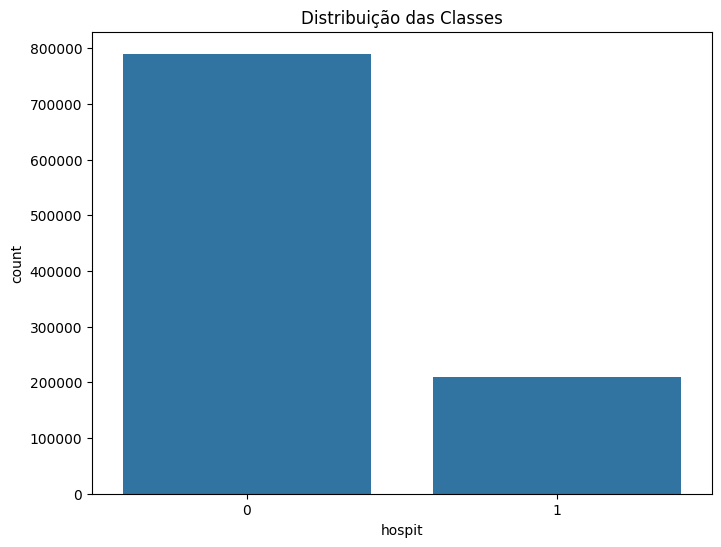

hospit
0    0.5
1    0.5
Name: proportion, dtype: float64


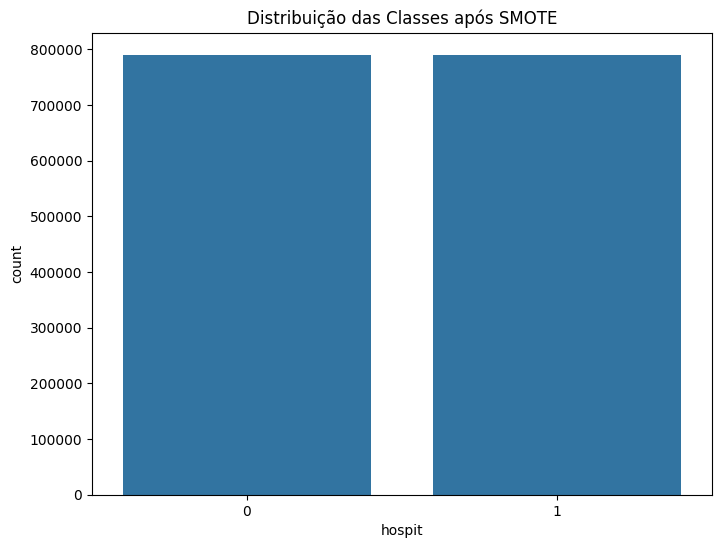

                            model  training_time  train_accuracy  \
0              LogisticRegression     147.401652        0.579696   
1          DecisionTreeClassifier      54.107037        0.611735   
2          RandomForestClassifier     847.197742        0.627283   
3  HistGradientBoostingClassifier     183.091105        0.629356   

   val_accuracy  test_accuracy  train_precision  test_precision  train_recall  \
0      0.579695       0.579756         0.582593        0.582670      0.579696   
1      0.611753       0.614451         0.612454        0.615106      0.611735   
2      0.627164       0.628682         0.627314        0.628701      0.627283   
3      0.629606       0.630928         0.629881        0.631695      0.629356   

   test_recall  train_f1   test_f1    val_f1  train_roc_auc  test_roc_auc  \
0     0.579756  0.575978  0.576020  0.575975       0.611489      0.612789   
1     0.614451  0.611114  0.613902  0.611124       0.647132      0.649648   
2     0.628682  0.6272

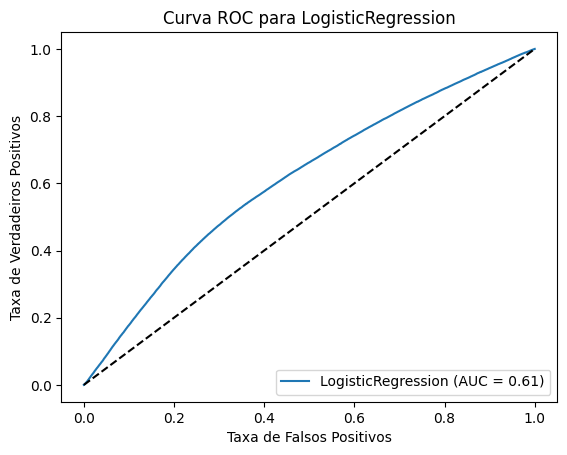

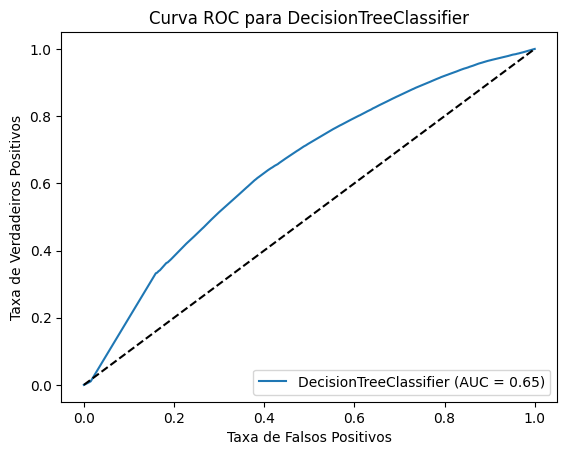

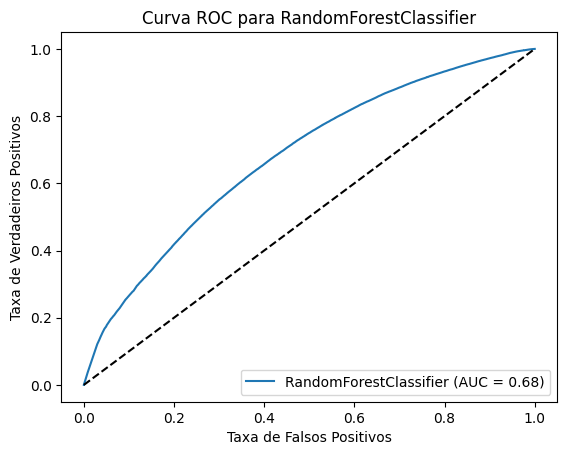

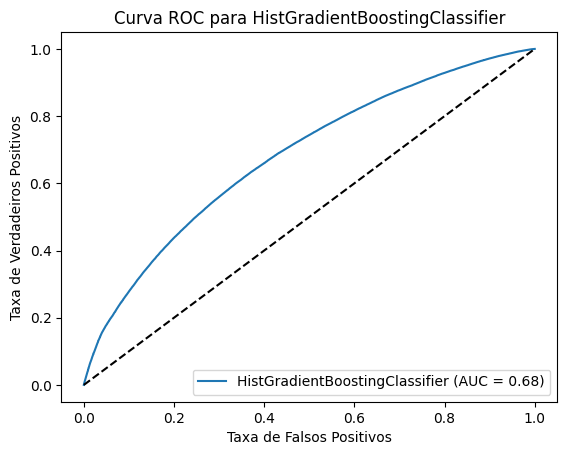

Melhor Modelo: HistGradientBoostingClassifier


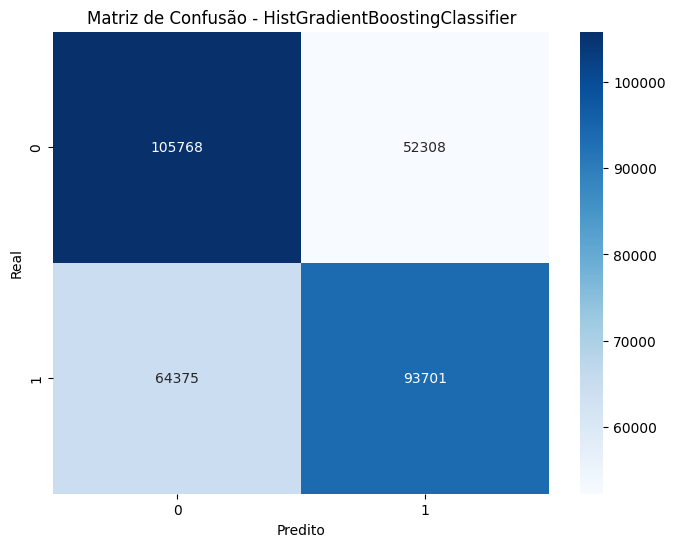

In [7]:
# Install libraries and dependencies
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, make_scorer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE  # for handling class imbalance (if needed)
import time
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import uniform, randint


# Data Loading
df = pd.read_csv('/content/sample_data/database.csv').drop_duplicates()  # Change the directory if needed.
print(f"O dataset contém {df.shape[0]} linhas antes da remoção de duplicatas.") #Print number of rows before removing duplicates

# Identify and remove duplicate rows
initial_rows = len(df)
df.drop_duplicates(inplace=True)
duplicates_removed = initial_rows - len(df)
print(f"Foram removidas {duplicates_removed} linhas duplicadas.")
print(f"O dataset agora contém {df.shape[0]} linhas.")

# Select 10,000 random rows from the DataFrame for faster processing and testing
sampled_df = df.sample(n=1000000, random_state=42)  # Set random_state for reproducibility
sampled_df.shape
df = sampled_df

# Check the data type of each column
print(f"O dataset contém {df.shape[0]} linhas e {df.shape[1]} colunas.")
df.info()

# Count unique patient_id
unique_patient_count = df['patient_id'].nunique()
print(f"Número de IDs de pacientes únicos: {unique_patient_count}")

# Check the unique values of the columns drug_0, drug_1, drug_2, drug_*
drug_columns = [col for col in df.columns if 'drug' in col.lower()]
for col in drug_columns:
    print(f'Valores únicos para {col}: {df[col].unique()}')


# Data Preprocessing

# Handle missing values. 'most_frequent' is a good starting point for categorical features,
imputer = SimpleImputer(strategy='most_frequent')
for col in df.columns:
    if df[col].isnull().any():  # Check if any nulls exist in each column
        df[col] = imputer.fit_transform(df[[col]])

# Feature Engineering:

date_columns = ['timestamp']
for col in date_columns:
    # Convert to datetime, handling errors
    df[col] = pd.to_datetime(df[col], errors='coerce')
    # Extract numerical features from the datetime column
    df[col + '_year'] = df[col].dt.year
    df[col + '_month'] = df[col].dt.month
    df[col + '_day'] = df[col].dt.day

    # Drop the original datetime column
    df = df.drop(col, axis=1)

# Convert specified columns to binary
columns_to_convert = ['drug_0', 'drug_1', 'drug_2', 'drug_3', 'drug_4', 'drug_5', 'drug_6', 'drug_7', 'drug_8', 'drug_9',
                     'drug_10', 'drug_11', 'drug_12', 'drug_13', 'drug_14', 'drug_15', 'drug_16', 'drug_17', 'drug_18']
df['hospit'] = df['hospit'].apply(lambda x: 1 if x > 0 else 0)
drug_columns = [col for col in df.columns if 'drug' in col.lower()]
for col in drug_columns:
    if col.startswith('drug_'):
        df[col] = df[col].apply(lambda x: 1 if x > 0 else 0)  # Convert to binary
        columns_to_convert.append(col)

for column in columns_to_convert:
    if column in df.columns:  # Check if the column exists
        try:
            df[column] = df[column].astype(int)
        except ValueError as e:
            print(f"Erro convertendo a coluna '{column}' para int: {e}")
            # Handle the error, e.g., replace non-numeric values or drop the column
            # Example: Replace non-numeric values with NaN and then impute
            df[column] = pd.to_numeric(df[column], errors='coerce')
            imputer = SimpleImputer(strategy='most_frequent')  # or 'mean', 'median' depending on your data
            df[column] = imputer.fit_transform(df[[column]])
            df[column] = df[column].astype(int)
            print(f"Coluna '{column}' convertida após o tratamento de valores não numéricos")

df.info()
df.head()


# Check class distribution
print(df['hospit'].value_counts(normalize=True))
plt.figure(figsize=(8, 6))
sns.countplot(x='hospit', data=df)
plt.title('Distribuição das Classes')
plt.show()


# 2. Data Splitting and Class Imbalance Handling

# Separate features (X) and target (y)
X = df.drop('hospit', axis=1)
y = df['hospit']


# Handle Class Imbalance: Check class distribution before deciding.

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X = X_resampled
y = y_resampled

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)  # stratify ensures class balance in split
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)



# check class distribution after the smote

print(y_resampled.value_counts(normalize=True))  # Check class distribution after applying SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x=y_resampled)
plt.title('Distribuição das Classes após SMOTE')
plt.show()


#Improved handling of potential errors
try:
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
except ValueError as e:
    print(f"Erro na escalonamento dos dados: {e}. Verifique se há colunas não numéricas ou outros problemas nos dados.")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

models = [
    LogisticRegression(max_iter=1000, solver='saga'),
    DecisionTreeClassifier(),
    RandomForestClassifier(), #Added RandomForestClassifier
    HistGradientBoostingClassifier()
    #SVC(probability=True)
]

param_dists = [
    {'C': uniform(0.1, 10), 'penalty': ['l1', 'l2'], 'solver': ['saga']},
    {'max_depth': randint(1, 20), 'min_samples_split': randint(2, 10)},
    {'n_estimators': randint(50,200), 'max_depth': randint(1,20), 'min_samples_split':randint(2,10)}, #Improved RandomForest parameters
    {'learning_rate': uniform(0.01, 0.3), 'max_iter': randint(50, 200)},
    {'C': uniform(0.1, 10), 'kernel': ['linear', 'rbf']}
]

#Use a custom scorer to handle potential errors during scoring
def weighted_f1_scorer(y_true, y_pred):
    try:
        return f1_score(y_true, y_pred, average='weighted')
    except ValueError as e:
        print(f"Erro ao calcular a pontuação F1 ponderada: {e}")
        return 0


all_results = []
for i, model in enumerate(models):
    start_time = time.time()
    random_search = RandomizedSearchCV(model, param_dists[i], n_iter=10, cv=5, scoring=make_scorer(weighted_f1_scorer), n_jobs=-1, random_state=42) #Using custom scorer

    try:
        random_search.fit(X_train, y_train)
    except ValueError as e:
        print(f"Erro ao ajustar o modelo {type(model).__name__}: {e}")
        continue #Skip to the next model if there's an error

    end_time = time.time()
    training_time = end_time - start_time
    best_model = random_search.best_estimator_

    try:
        y_train_pred = cross_val_predict(best_model, X_train, y_train, cv=5)
        y_train_prob = cross_val_predict(best_model, X_train, y_train, cv=5, method='predict_proba')[:, 1] if hasattr(best_model, "predict_proba") else None
        val_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring=make_scorer(weighted_f1_scorer)) #Using custom scorer
        avg_val_f1 = np.mean(val_scores)
        y_test_pred = best_model.predict(X_test)
        y_test_prob = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None
        conf_matrix = confusion_matrix(y_test, y_test_pred) #Added confusion matrix calculation

        results = {
            'model': type(best_model).__name__,
            'training_time': training_time,
            'train_accuracy': accuracy_score(y_train, y_train_pred),
            'val_accuracy': np.mean(cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')),
            'test_accuracy': accuracy_score(y_test, y_test_pred),
            'train_precision': precision_score(y_train, y_train_pred, average='weighted'),
            'test_precision': precision_score(y_test, y_test_pred, average='weighted'),
            'train_recall': recall_score(y_train, y_train_pred, average='weighted'),
             'test_recall': recall_score(y_test, y_test_pred, average='weighted'),
            'train_f1': f1_score(y_train, y_train_pred, average='weighted'),
            'test_f1': f1_score(y_test, y_test_pred, average='weighted'),
            'val_f1': avg_val_f1,
            'train_roc_auc': roc_auc_score(y_train, y_train_prob) if y_train_prob is not None else np.nan,
            'test_roc_auc': roc_auc_score(y_test, y_test_prob) if y_test_prob is not None else np.nan,
            'test_classification_report': classification_report(y_test, y_test_pred),
            'test_conf_matrix': conf_matrix,
            'best_model': best_model
        }
        all_results.append(results)
    except ValueError as e:
        print(f"Erro ao avaliar o modelo {type(best_model).__name__}: {e}")


results_df = pd.DataFrame(all_results)
print(results_df)

#Plot ROC curves
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

for i in range(len(models)):
    model_name = results_df['model'].iloc[i]

    # Get the fitted model from results_df using the model name
    fitted_model = results_df.loc[results_df['model'] == model_name, 'best_model'].values[0] #Use fitted model

    y_pred_prob = fitted_model.predict_proba(X_test)[:, 1] if hasattr(fitted_model, "predict_proba") else None #Handle models without predict_proba
    if y_pred_prob is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random classifier)
        plt.xlabel('Taxa de Falsos Positivos')
        plt.ylabel('Taxa de Verdadeiros Positivos')
        plt.title(f'Curva ROC para {model_name}')
        plt.legend(loc='lower right')
        plt.show()
    else:
        print(f"O modelo {model_name} não possui o método predict_proba. A curva ROC não pode ser plotada.")
#Find best model and plot relevant graphs.
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming results_df is already created as in the previous code

# Function to plot the confusion matrix
def plot_confusion_matrix(conf_matrix, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()

# Find the best model based on a chosen metric (e.g., test_f1)
best_model_index = results_df['test_f1'].idxmax()
best_model_name = results_df.loc[best_model_index, 'model']
best_model_results = results_df.loc[best_model_index]

# Get the actual fitted model object using the best_model_index
best_model = results_df.loc[best_model_index, 'best_model']


print(f"Melhor Modelo: {best_model_name}")

# Plot relevant graphs for the best model
# 1. Confusion Matrix (Test Set)
plot_confusion_matrix(best_model_results['test_conf_matrix'], best_model_name)

# 2. ROC Curve (Test Set) - already plotted above for all models

# 3. Feature Importance (if applicable)
if best_model_name in ['DecisionTreeClassifier', 'RandomForestClassifier']:
    importances = best_model.feature_importances_ # Use 'best_model' here as well
    # Get feature names from the original DataFrame before scaling
    feature_names = X_resampled.columns  # X_resampled is your DataFrame before scaling
    feature_importance_df = pd.DataFrame({'Característica':feature_names, 'Importância':importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importância', ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x='Importância', y='Característica', data=feature_importance_df)
    plt.title(f"Importância das Características - {best_model_name}")
    plt.show()

In [8]:
display(results_df)

,model,training_time,train_accuracy,val_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,val_f1,train_roc_auc,test_roc_auc,test_classification_report,test_conf_matrix,best_model
0,LogisticRegression,147.401652,0.579696,0.579695,0.579756,0.582593,0.582670,0.579696,0.579756,0.575978,0.576020,0.575975,0.611489,0.612789,precision recall f1-score ...,"[[76806, 81270], [51591, 106485]]","LogisticRegression(C=7.180725777960454, max_it..."
1,DecisionTreeClassifier,54.107037,0.611735,0.611753,0.614451,0.612454,0.615106,0.611735,0.614451,0.611114,0.613902,0.611124,0.647132,0.649648,precision recall f1-score ...,"[[91170, 66906], [54986, 103090]]","DecisionTreeClassifier(max_depth=15, min_sampl..."
2,RandomForestClassifier,847.197742,0.627283,0.627164,0.628682,0.627314,0.628701,0.627283,0.628682,0.627260,0.628668,0.627140,0.677629,0.679561,precision recall f1-score ...,"[[98426, 59650], [57743, 100333]]","(DecisionTreeClassifier(max_depth=15, max_feat..."
3,HistGradientBoostingClassifier,183.091105,0.629356,0.629606,0.630928,0.629881,0.631695,0.629356,0.630928,0.628980,0.630389,0.628897,0.679742,0.681329,precision recall f1-score ...,"[[105768, 52308], [64375, 93701]]",HistGradientBoostingClassifier(learning_rate=0...


In [9]:
if best_model_name in ['DecisionTreeClassifier', 'RandomForestClassifier']:
    importances = best_model.feature_importances_ # Use 'best_model' here as well
    # Get feature names from the original DataFrame before scaling
    feature_names = X_resampled.columns  # X_resampled is your DataFrame before scaling
    feature_importance_df = pd.DataFrame({'Característica':feature_names, 'Importância':importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importância', ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x='Importância', y='Característica', data=feature_importance_df)
    plt.title(f"Importância das Características - {best_model_name}")
    plt.show()

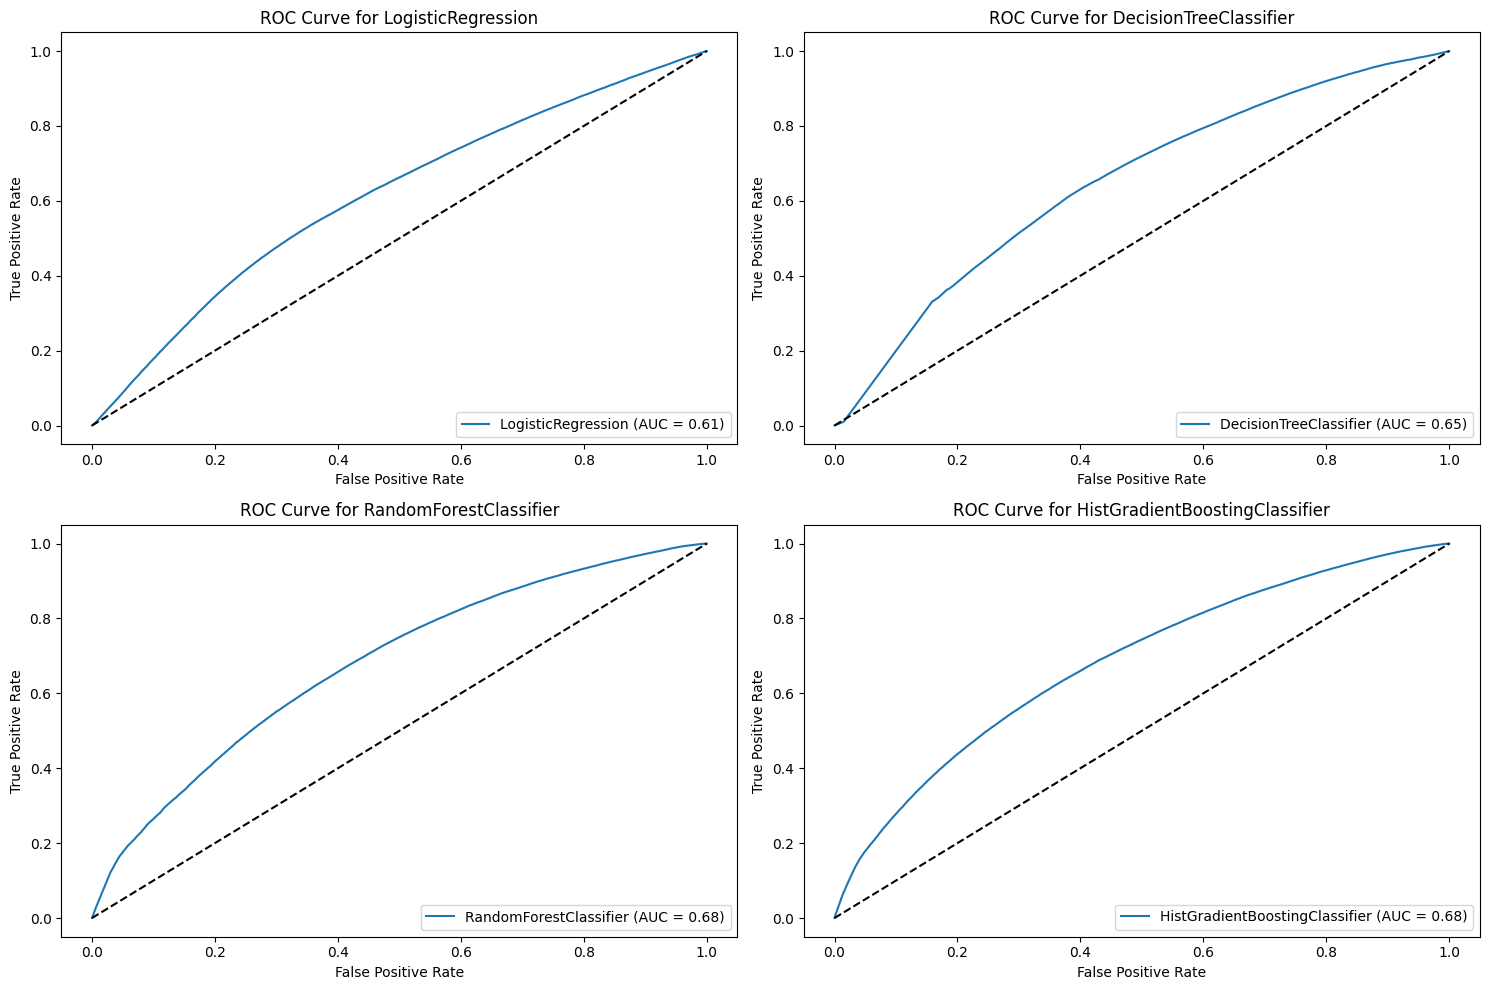

In [14]:
# plot the ROC graphs 3 per line

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming 'results_df' and 'X_test', 'y_test' are defined from previous code

num_plots_per_row = 2
num_models = len(results_df)
num_rows = (num_models + num_plots_per_row - 1) // num_plots_per_row

fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(15, 5 * num_rows))
axes = axes.ravel()  # Flatten the axes array for easier indexing

for i in range(num_models):
    model_name = results_df['model'].iloc[i]
    fitted_model = results_df.loc[results_df['model'] == model_name, 'best_model'].values[0]

    try:
        y_pred_prob = fitted_model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)

        axes[i].plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
        axes[i].plot([0, 1], [0, 1], 'k--')
        axes[i].set_xlabel('False Positive Rate')
        axes[i].set_ylabel('True Positive Rate')
        axes[i].set_title(f'ROC Curve for {model_name}')
        axes[i].legend(loc='lower right')
    except AttributeError:
        print(f"Model {model_name} does not have predict_proba method.")
        axes[i].text(0.5, 0.5, f"Model {model_name} does not have predict_proba method.", ha='center', va='center')
    except ValueError as e:
        print(f"Error plotting ROC for {model_name}: {e}")
        axes[i].text(0.5, 0.5, f"Error plotting ROC for {model_name}: {e}", ha='center', va='center')

# Hide any unused subplots
for i in range(num_models, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [12]:
# convert training time in minutes and display
results_df['training_time_minutes'] = results_df['training_time'] / 60
display(results_df[['model', 'training_time_minutes', 'train_accuracy', 'val_accuracy', 'test_accuracy',
                    'train_precision', 'test_precision', 'train_recall', 'test_recall',
                    'train_f1', 'test_f1', 'val_f1', 'train_roc_auc', 'test_roc_auc']])  # Corrected column names
display(results_df)

,model,training_time_minutes,train_accuracy,val_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,val_f1,train_roc_auc,test_roc_auc
0,LogisticRegression,2.456694,0.579696,0.579695,0.579756,0.582593,0.582670,0.579696,0.579756,0.575978,0.576020,0.575975,0.611489,0.612789
1,DecisionTreeClassifier,0.901784,0.611735,0.611753,0.614451,0.612454,0.615106,0.611735,0.614451,0.611114,0.613902,0.611124,0.647132,0.649648
2,RandomForestClassifier,14.119962,0.627283,0.627164,0.628682,0.627314,0.628701,0.627283,0.628682,0.627260,0.628668,0.627140,0.677629,0.679561
3,HistGradientBoostingClassifier,3.051518,0.629356,0.629606,0.630928,0.629881,0.631695,0.629356,0.630928,0.628980,0.630389,0.628897,0.679742,0.681329


,model,training_time,train_accuracy,val_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,val_f1,train_roc_auc,test_roc_auc,test_classification_report,test_conf_matrix,best_model,training_time_minutes
0,LogisticRegression,147.401652,0.579696,0.579695,0.579756,0.582593,0.582670,0.579696,0.579756,0.575978,0.576020,0.575975,0.611489,0.612789,precision recall f1-score ...,"[[76806, 81270], [51591, 106485]]","LogisticRegression(C=7.180725777960454, max_it...",2.456694
1,DecisionTreeClassifier,54.107037,0.611735,0.611753,0.614451,0.612454,0.615106,0.611735,0.614451,0.611114,0.613902,0.611124,0.647132,0.649648,precision recall f1-score ...,"[[91170, 66906], [54986, 103090]]","DecisionTreeClassifier(max_depth=15, min_sampl...",0.901784
2,RandomForestClassifier,847.197742,0.627283,0.627164,0.628682,0.627314,0.628701,0.627283,0.628682,0.627260,0.628668,0.627140,0.677629,0.679561,precision recall f1-score ...,"[[98426, 59650], [57743, 100333]]","(DecisionTreeClassifier(max_depth=15, max_feat...",14.119962
3,HistGradientBoostingClassifier,183.091105,0.629356,0.629606,0.630928,0.629881,0.631695,0.629356,0.630928,0.628980,0.630389,0.628897,0.679742,0.681329,precision recall f1-score ...,"[[105768, 52308], [64375, 93701]]",HistGradientBoostingClassifier(learning_rate=0...,3.051518


In [15]:

# To display the best parameters for each model:
for i, model in enumerate(models):
    model_name = type(model).__name__
    try:
        best_params = random_search.best_params_ # Access best parameters from random search object
        print(f"Best parameters for {model_name}: {best_params}")
    except NameError:
        print(f"Best parameters for {model_name} could not be displayed.")
    except AttributeError:
      print(f"Could not find the best parameters for {model_name}. Check the results_df.")

#To display the best parameters for each model using results_df DataFrame:
for index, row in results_df.iterrows():
    model_name = row['model']
    #print(row) #uncomment to inspect the content of the row
    try:
      print(f"Best Parameters for {model_name}: {row['best_model'].get_params()}")
    except AttributeError:
      print(f"Could not find the best parameters for {model_name} in the results_df. Check the best_model column.")

Best parameters for LogisticRegression: {'learning_rate': 0.19033450352296263, 'max_iter': 180}
Best parameters for DecisionTreeClassifier: {'learning_rate': 0.19033450352296263, 'max_iter': 180}
Best parameters for RandomForestClassifier: {'learning_rate': 0.19033450352296263, 'max_iter': 180}
Best parameters for HistGradientBoostingClassifier: {'learning_rate': 0.19033450352296263, 'max_iter': 180}
Best Parameters for LogisticRegression: {'C': 7.180725777960454, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Best Parameters for DecisionTreeClassifier: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 4, 'min_weight_f